# Transverse field Ising model to demo primitives (black boxes that hide a lot of the hardware specific stuff)

TFIM simulation from https://www.nature.com/articles/s41586-023-06096-3

In [22]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

# Will need sqrtY gate but only have Ygate, so make sqrtY gate. UnitaryGate let's us make a new gate. 
SYGate = UnitaryGate(YGate().power(1/2), label=r'$\sqrt{Y}$')
SYdgGate = UnitaryGate(SYGate.inverse(), label=r'$\sqrt{Y}^\dag$')           # Also need sqrt(y)^dagger

def generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=False, layer_barriers=False):
    """
        num_qubits (int): the number of qubits in the 1d chain
        num_trotter_steps (int): the number of trotter steps
        rx_angle (float): the Rx rotation angle coming from the transverse field
        num_cl_bits (int): the number of classical bits in the classical register
        trotter_barriers (logical): option to force barriers between trotter steps, default False
        layer_barriers (logical): option to force barriers between odd/even layers, default False
    """
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    
    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    """
        qc (QuantumCircuit): the qiskit circuit
        rx_angle (float): the Rx rotation angle coming from the transverse field
        layer_barriers (logical): option to force barriers between odd/even layers, default False
    """
    # For the Rzz gates, use the circuit identity from the paper that:
    # q0, q1 --> Rzz(-pi/2) -->
    # equivalent to 
    # q0 -- S^dagger --------- CNOT(c) -----------------
    # q1 -- S^dagger - sqrtY - CNOT(t) - sqrtY^dagger --

    # Split into even and odd layers to reduce idle time and circuit depth. Even layer Z0Z1 Z2Z3 Z4Z5 etc, odd layer Z1Z2 Z3Z4 Z5Z6 etc
    # Adding Rzz in the even layers - the step of  starting at 0 makes it the even layers.
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i,i+1])          # sdg is S^dagger 
        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    # Adding Rzz in the odd layers - the step of 2 starting at 1 makes it the odd layers.
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i,i+1])          # sdg is S^dagger 
        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    # Apply Rx gate to all qubits in the circuit
    qc.rx(rx_angle, list(range(qc.num_qubits)))

        

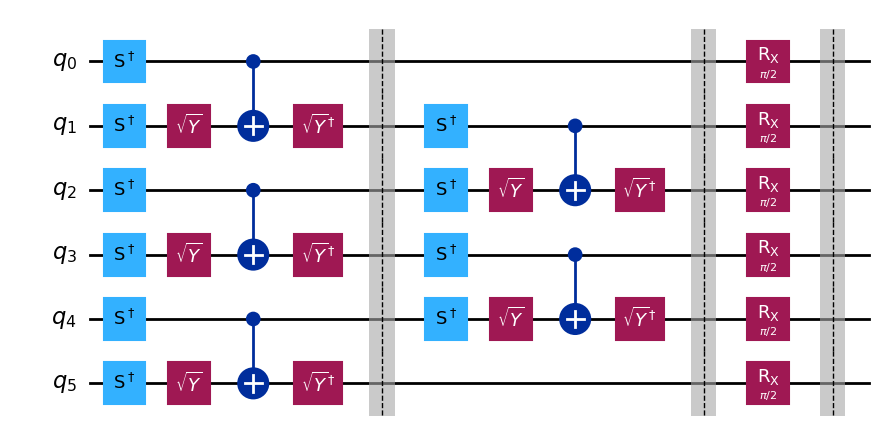

In [2]:
num_qubits = 6
num_trotter_steps = 1
rx_angle = 0.5*np.pi

qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, num_cl_bits=0, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)       # fold=-1 puts it all onto one line

# This is the circuit for the forward time evolution (the U part, but not the Udagger part)

In [3]:
# Now for the backwards time evolution (the Udagger part)

def append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=False, layer_barriers=False):
    """
        qc (QuantumCircuit): the qiskit circuit
        num_qubits (int): the number of qubits in the 1d chain
        num_trotter_steps (int): the number of trotter steps
        rx_angle (float): the Rx rotation angle coming from the transverse field
        trotter_barriers (logical): option to force barriers between trotter steps, default False
        layer_barriers (logical): option to force barriers between odd/even layers, default False
    """

    for trotter_step in range(num_trotter_steps):
        add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()
    # No return qc since we are appending to the forward circuit. 

def add_mirrored_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers=False):
    """
        qc (QuantumCircuit): the qiskit circuit
        rx_angle (float): the Rx rotation angle coming from the transverse field
        layer_barriers (logical): option to force barriers between odd/even layers, default False
    """
    # For the Rzz gates, use the circuit identity from the paper that:
    # q0, q1 --> Rzz(-pi/2) -->
    # equivalent to 
    # q0 -- S^dagger --------- CNOT(c) -----------------
    # q1 -- S^dagger - sqrtY - CNOT(t) - sqrtY^dagger --

    # Apply Rx gate to all qubits in the circuit. This is inverted, so uses -rx_angle.
    qc.rx(-rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()
    # Split into even and odd layers to reduce idle time and circuit depth. Even layer Z0Z1 Z2Z3 Z4Z5 etc, odd layer Z1Z2 Z3Z4 Z5Z6 etc
    # Adding Rzz in the odd layers - the step of 2 starting at 1 makes it the odd layers. Gates are inverted and order reversed. 
    for i in range(1, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)            # CNOT is its own inverse. 
        qc.append(SYdgGate, [i+1])
        qc.s([i,i+1])          # s instead of sdg 
    if layer_barriers:
        qc.barrier()
    # Adding Rzz in the even layers - the step of  starting at 0 makes it the even layers. Gates are inverted and order reversed. 
    for i in range(0, qc.num_qubits-1, 2):
        qc.append(SYGate, [i+1])
        qc.cx(i,i+1)
        qc.append(SYdgGate, [i+1])
        qc.s([i,i+1])          
        

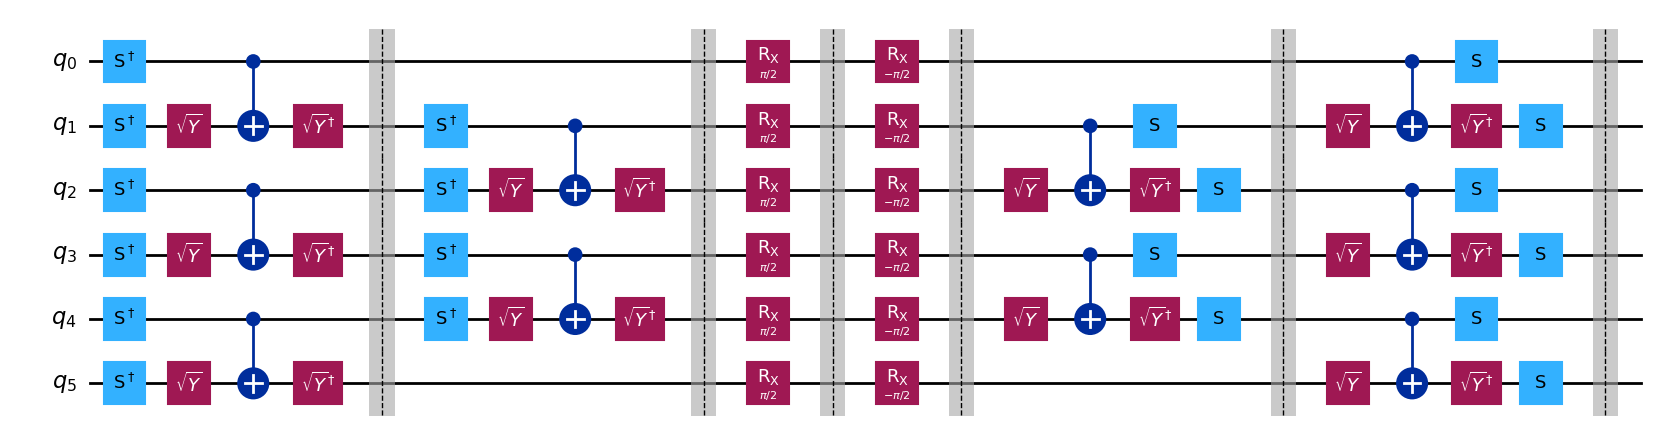

In [4]:
append_mirrored_1d_tfim_circuit(qc, num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl',fold=-1)

# Have a circuit which is just U Udagger so is basically just the identity. 

# Step 1: Map the problem to circuits and observables

In [18]:
# Let's increase the number of trotter steps, so the circuit depth, and see what happens to the survival probability of the all-zero initial state.

max_trotter_steps = 10
num_qubits = 100
# Measure the middle two qubits
measured_qubits = [49,50]

qc_list = []
for trotter_step in range(max_trotter_steps):
    qc = generate_1d_tfim_circuit(num_qubits, 1, rx_angle, num_cl_bits=len(measured_qubits), trotter_barriers=True, layer_barriers=True)
    append_mirrored_1d_tfim_circuit(qc, num_qubits, 1, rx_angle, trotter_barriers=True, layer_barriers=True)
    qc.measure(measured_qubits, list(range(len(measured_qubits))))
    qc_list.append(qc)

# Only draw it if the number of qubits isn't too large! 
# qc_list[1].draw(output='mpl')   

# Step 2: Optimize

In [19]:
from qiskit import transpile 
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)
print("Done getting the backend")

qc_transpiled_list = transpile(qc_list, backend=backend, optimization_level=1)

/var/folders/rr/zb03ch_925s5zfqc9w_mlvdh0000gn/T/ipykernel_12231/3401564241.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


Done getting the backend


# Step 3: Execute on hardware

In [20]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend)
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"

job = sampler.run(qc_transpiled_list)
print(job.job_id())

d0jazpyvpqf00080saz0


# Step 4: Post-processing and plot

In [16]:
job_id = "d0jazpyvpqf00080saz0"
job = service.job(job_id)

survival_probability_list = []
for trotter_step in range(max_trotter_steps):
    try:
        data = job.result()[trotter_step].data
        survival_probability_list.append(data.c.get_counts()['0' * len(measured_qubits)] / data.c.num_shots)
        # '0' * len(measured_qubits) is the all-zero bit string, so we are trying to get the number of times we observed the all-zero bit string at the end, divided by the total number 
        # of shots, as this gives us the survival probability
    except:
        # If the noise is very strong then the all-zero state will never survive, so we won't be able to get data. 
        survival_probability_list.append(0)


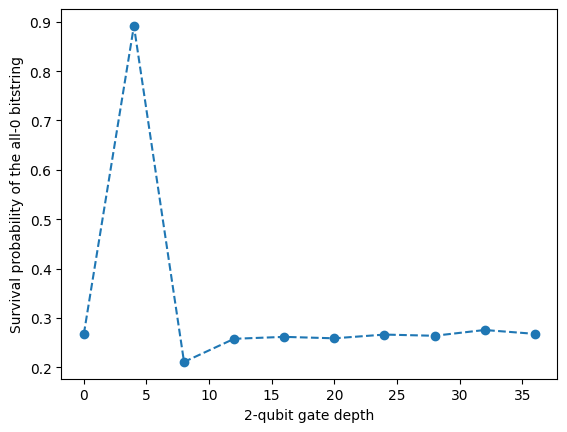

In [17]:
import matplotlib.pyplot as plt

# Every trotter step has two CNOT gates in the even layers and two CNOT gates in the odd layers, so has a 2-qubit gate depth of 4 per trotter step. 
circuit_depth_list = list(range(0, 4 * max_trotter_steps, 4))

plt.plot(circuit_depth_list, survival_probability_list, '--o')
plt.xlabel('2-qubit gate depth')
plt.ylabel('Survival probability of the all-0 bitstring')
plt.show()

## $M_z$ Estimator

# Step 1: Mapping the problem

In [24]:
from qiskit.circuit import Parameter

num_qubits = 100
num_trotter_steps = 2
rx_angle = Parameter("rx_angle")            # Allows for a sweep over the Rx angle
qc = generate_1d_tfim_circuit(num_qubits, num_trotter_steps, rx_angle)

from qiskit.quantum_info import SparsePauliOp

middle_index = num_qubits // 2
observable = SparsePauliOp("I" * middle_index + "Z" + "I" * (middle_index-1))       # Operator we will measure

# Step 2: Optimize the circuit

In [25]:
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.backend(backend_name)

qc_transpiled = transpile(qc, backend, optimization_level=1)
observable = observable.apply_layout(qc_transpiled.layout)

/var/folders/rr/zb03ch_925s5zfqc9w_mlvdh0000gn/T/ipykernel_12231/2837147343.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


# Step 3: Execute on quantum hardware

In [ ]:
from qiskit_ibm_runtime import EstimatorV2, EstimatorOptions

# Sweep over Rx angle
min_rx_angle = 0
max_rx_range = np.pi/2
num_rx_angle = 12
rx_angle_list = np.linspace(min_rx_angle, max_rx_range, num_rx_angle)

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = EstimatorV2(backend, options)

job = estimator.run([(qc_transpiled, observable, rx_angle_list)])
print(job.job_id())


<bound method BasePrimitiveJob.job_id of <RuntimeJobV2('d0jb820crrag008n58j0', 'estimator')>>


# Step 4: Post-processing and plotting

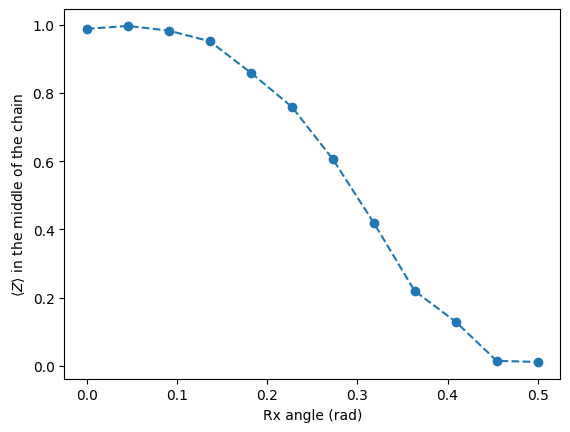

In [29]:
job_id = "d0jb820crrag008n58j0"
job = service.job(job_id)

exp_val_list = job.result()[0].data.evs

plt.plot(rx_angle_list/np.pi, exp_val_list, '--o')
plt.xlabel(r'Rx angle (rad)')
plt.ylabel(r'$\langle Z\rangle$ in the middle of the chain')
plt.show()

# Very similar to fig 1a in the paper!